In [1]:
!unzip plant-village.zip -d plant_village

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: plant_village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plant_village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plant_village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plant_village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plant_village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plant_village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plant_village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0922e026-

In [2]:
#Definición de clases para el entrenamiento
import os
import shutil
data_dir = '/content/plant_village/PlantVillage/'
classes_to_keep = ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',
                   'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
                   'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight',
                   'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot',
                   'Tomato_Spider_mites_Two_spotted_spider_mite',
                   'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
                   'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']

filtered_dir = 'filtered_data'
os.makedirs(filtered_dir, exist_ok=True)

for class_name in classes_to_keep:
    src = os.path.join(data_dir, class_name)
    dst = os.path.join(filtered_dir, class_name)
    #shutil.copytree(src, dst)
    shutil.copytree(src, dst, dirs_exist_ok=True)

In [3]:
#Importación del generador de imágenes
!pip install tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 224
batch_size = 32

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    filtered_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    filtered_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
history = model.fit(train_gen, validation_data=val_gen, epochs=10)
model.save('plant_disease_model.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 245s 442ms/step - accuracy: 0.6573 - loss: 1.0870 - val_accuracy: 0.8532 - val_loss: 0.4207
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 209s 404ms/step - accuracy: 0.8547 - loss: 0.4367 - val_accuracy: 0.8884 - val_loss: 0.3338
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 209s 404ms/step - accuracy: 0.8722 - loss: 0.3763 - val_accuracy: 0.8954 - val_loss: 0.3025
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 208s 403ms/step - accuracy: 0.8882 - loss: 0.3261 - val_accuracy: 0.8928 - val_loss: 0.2957
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 209s 404ms/step - accuracy: 0.8970 - loss: 0.2992 - val_accuracy: 0.9124 - val_loss: 0.2593
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 209s 404ms/step - accuracy: 0.9015 - loss: 0.2835 - val_accuracy: 0.9051 - val_loss: 0.2749
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 209s 405ms/step - accuracy: 0.9003 - loss: 0.2849 - val_accuracy: 0.9187 - val_loss: 0.2447
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 209s 404ms/step - accuracy: 0.9098 -

In [6]:
from google.colab import files
files.download('plant_disease_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
#probaremos  el modelo entrenado con una imagen

import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files

# Cargar el modelo
model = load_model('plant_disease_model.h5')

# Subir la imagen
uploaded = files.upload()

for fn in uploaded.keys():
  # Preprocesar la imagen
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0  # Normalizar la imagen

  # Realizar la predicción
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
classes

Saving 92b4bad6-4326-4de7-8a65-eea919719730___YLCV_GCREC 2945.JPG to 92b4bad6-4326-4de7-8a65-eea919719730___YLCV_GCREC 2945.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
92b4bad6-4326-4de7-8a65-eea919719730___YLCV_GCREC 2945.JPG


array([[4.1557819e-09, 2.1359243e-08, 3.2750834e-13, 7.4745030e-11,
        4.3439617e-14, 6.2170351e-08, 9.5390760e-06, 2.4067907e-07,
        1.2138705e-06, 1.8790272e-08, 4.1148311e-07, 1.6111337e-06,
        9.9998665e-01, 2.8419271e-07, 8.7005559e-12]], dtype=float32)

In [8]:
# Esta sección de código utiliza el modelo entrenado, para predecir la enfermedad de la planta

import numpy as np
from tensorflow.keras.preprocessing import image

# Cargar el modelo (asegúrate de que 'plant_disease_model.h5' esté en el mismo directorio o especifica la ruta correcta)
model = load_model('plant_disease_model.h5')

# Obtener las etiquetas de las clases
class_labels = list(train_gen.class_indices.keys())  # Usa train_gen definido anteriormente

# Subir la imagen
uploaded = files.upload()

for fn in uploaded.keys():
  # Preprocesar la imagen
  path = fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x / 255.0  # Normalizar la imagen

  # Realizar la predicción
  images = np.vstack([x])
  predictions = model.predict(images, batch_size=10)
  predicted_class_index = np.argmax(predictions)
  predicted_class_label = class_labels[predicted_class_index]
  confidence = predictions[0][predicted_class_index]

  print(f"Imagen: {fn}")
  print(f"Predicción: {predicted_class_label}")
  print(f"Confianza: {confidence:.2f}")

Saving feb1b0d0-aa78-4ba8-93a1-384229fc92fd___Com.G_TgS_FL 0715.JPG to feb1b0d0-aa78-4ba8-93a1-384229fc92fd___Com.G_TgS_FL 0715.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Imagen: feb1b0d0-aa78-4ba8-93a1-384229fc92fd___Com.G_TgS_FL 0715.JPG
Predicción: Tomato__Target_Spot
Confianza: 1.00


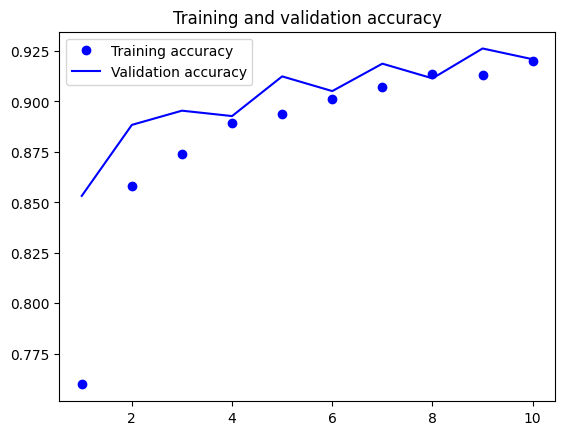

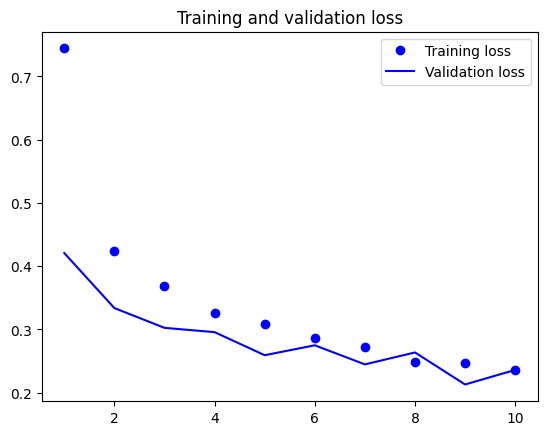

129/129 ━━━━━━━━━━━━━━━━━━━━ 48s 347ms/step


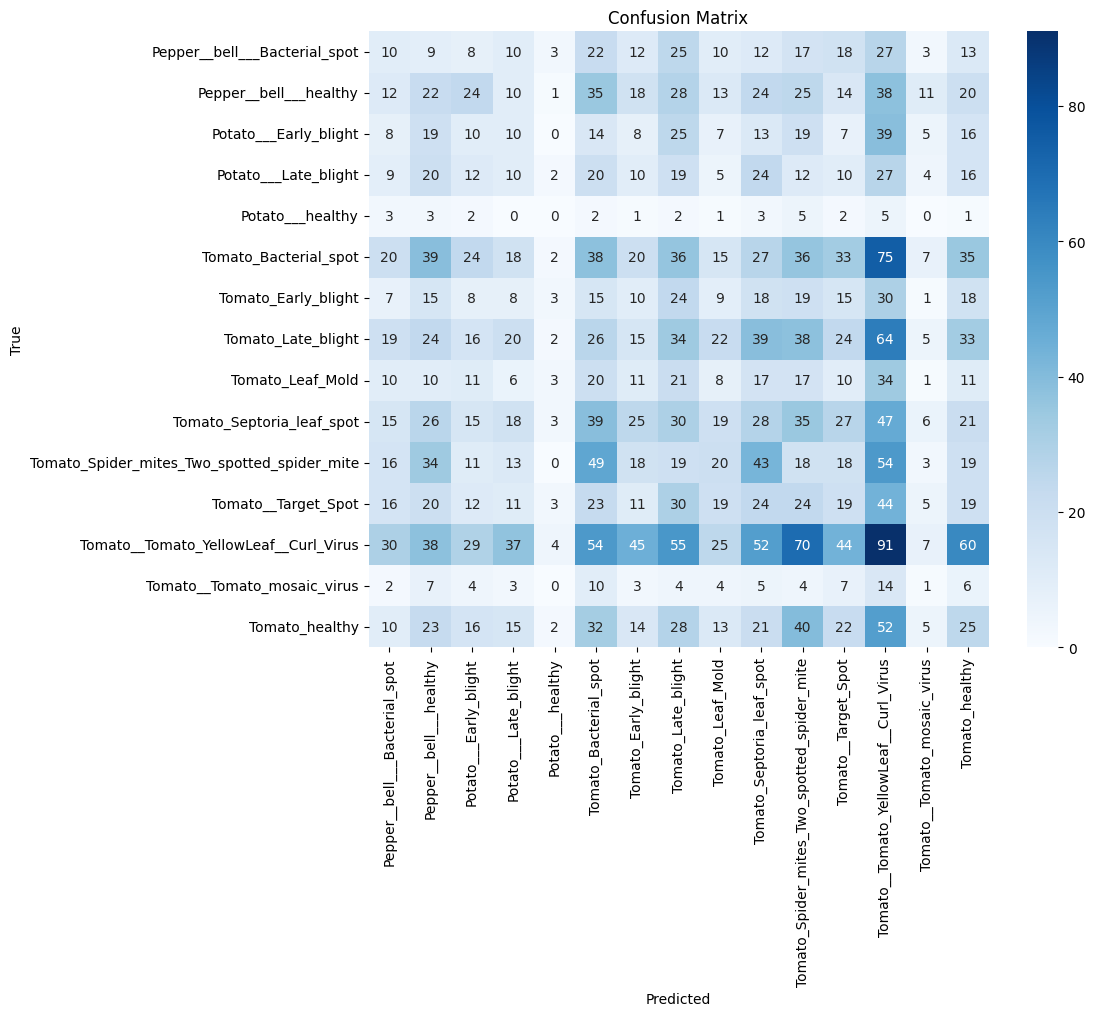

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.05      0.05      0.05       199
                     Pepper__bell___healthy       0.07      0.07      0.07       295
                      Potato___Early_blight       0.05      0.05      0.05       200
                       Potato___Late_blight       0.05      0.05      0.05       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.10      0.09      0.09       425
                        Tomato_Early_blight       0.05      0.05      0.05       200
                         Tomato_Late_blight       0.09      0.09      0.09       381
                           Tomato_Leaf_Mold       0.04      0.04      0.04       190
                  Tomato_Septoria_leaf_spot       0.08      0.08      0.08       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.05      0.05

In [11]:
import numpy as np
import matplotlib.pyplot as plt # Import matplotlib.pyplot with alias plt
# Obtener las métricas de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Graficar la precisión
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Graficar la pérdida
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Calcular y mostrar otras métricas
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Obtener predicciones para el conjunto de validación
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Informe de clasificación
print(classification_report(y_true, y_pred, target_names=class_labels))